# **<center> Predict attributes from LMs' embeddings </center>**

## Imports

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import geopandas as gpd
from tqdm import tqdm

In [2]:
import warnings

In [3]:
from matplotlib import rc
rc('text', usetex=True)

%config Completer.use_jedi = False

In [4]:
from scipy import stats

In [5]:
from sklearn import linear_model
from sklearn.svm import SVC

In [6]:
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score

In [7]:
from sklearn.metrics import explained_variance_score as evs, mean_squared_error as mse, make_scorer

## Data Loading

In [8]:
models = ['bert','bertLarge','gpt2','roberta','mpnet']
contexts = ['I come from', 'He lives in', 'She moved to']
short_ctxts = ['come','lives','moved']

In [9]:
cities = pd.read_csv('./csv/worldcitiespop.csv',header=0,dtype={'AccentCity':'str','Region':'object'}).dropna().drop('Region',axis=1)
cities = cities[cities.Population>100000].reset_index(drop=True)
cities

,Country,City,AccentCity,Population,Latitude,Longitude
0,ae,abu dhabi,Abu Dhabi,603687.0,24.466667,54.366667
1,ae,dubai,Dubai,1137376.0,25.258172,55.304717
2,ae,sharjah,Sharjah,543942.0,25.357310,55.403304
3,af,baglan,Baglan,108481.0,36.130684,68.708286
4,af,gardez,Gardez,103732.0,33.597439,69.225922
...,...,...,...,...,...,...
3522,zw,gweru,Gweru,201879.0,-19.450000,29.816667
3523,zw,harare,Harare,2213701.0,-17.817778,31.044722
3524,zw,kadoma,Kadoma,100276.0,-18.350000,29.916667
3525,zw,kwekwe,Kwekwe,116332.0,-18.916667,29.816667


In [10]:
#more than 500'000 citizens
big_cities = cities[cities.Population > 5e5]
big_cities

,Country,City,AccentCity,Population,Latitude,Longitude
0,ae,abu dhabi,Abu Dhabi,603687.0,24.466667,54.366667
1,ae,dubai,Dubai,1137376.0,25.258172,55.304717
2,ae,sharjah,Sharjah,543942.0,25.357310,55.403304
8,af,kabul,Kabul,3043589.0,34.516667,69.183333
16,am,yerevan,Yerevan,1093499.0,40.181111,44.513611
...,...,...,...,...,...,...
3499,za,soweto,Soweto,1695094.0,-26.267812,27.858492
3501,za,tembisa,Tembisa,511671.0,-25.996363,28.226802
3517,zm,lusaka,Lusaka,1267458.0,-15.416667,28.283333
3520,zw,bulawayo,Bulawayo,897249.0,-20.150000,28.583333


In [11]:
capitals = pd.read_csv('./csv/country-capitals.csv').drop(['ContinentName','CountryCode'], axis=1)
capitals

,CountryName,CapitalName,Latitude,Longitude
0,Somaliland,Hargeisa,9.550000,44.050000
1,South Georgia and South Sandwich Islands,King Edward Point,-54.283333,-36.500000
2,French Southern and Antarctic Lands,Port-aux-Français,-49.350000,70.216667
3,Palestine,Jerusalem,31.766667,35.233333
4,Aland Islands,Mariehamn,60.116667,19.900000
...,...,...,...,...
237,Zimbabwe,Harare,-17.816667,31.033333
238,Northern Cyprus,North Nicosia,35.183333,33.366667
239,Hong Kong,Hong Kong,22.302711,114.177216
240,British Indian Ocean Territory,Diego Garcia,-7.300000,72.400000


In [12]:
countries = pd.read_csv('./csv/countries_extended.csv',keep_default_na=False,na_values=['','..'])
countries

,Unnamed: 0,Name,Code,Latitude,Longitude,HDI,Population,GDP,GPD per cap.,GNI per cap.
0,0,Afghanistan,AF,33.0000,65.0,0.511,38.0,83.8,2202.0,2229.0
1,1,Albania,AL,41.0000,20.0,0.795,2.9,39.9,13962.0,13998.0
2,2,Algeria,DZ,28.0000,3.0,0.748,43.1,488.6,11350.0,11174.0
3,3,American Samoa,AS,-14.3333,-170.0,NaN,NaN,NaN,NaN,NaN
4,4,Andorra,AD,42.5000,1.5,0.868,0.1,NaN,NaN,56000.0
...,...,...,...,...,...,...,...,...,...,...
244,244,Western Sahara,EH,24.5000,-13.0,NaN,NaN,NaN,NaN,NaN
245,245,Yemen,YE,15.0000,48.0,0.470,29.2,NaN,NaN,1594.0
246,246,Zambia,ZM,-15.0000,30.0,0.584,17.9,62.1,3479.0,3326.0
247,247,Zimbabwe,ZW,-20.0000,30.0,0.571,14.6,41.5,2836.0,2666.0


In [13]:
datasets = {model_name : {ctx : pd.DataFrame(np.load('embd_files/'+model_name+'_'+ctx+'_cities.npy')) for ctx in short_ctxts} for model_name in models}
datasets_capitals = {model_name : {ctx : pd.DataFrame(np.load('embd_files/'+model_name+'_'+ctx+'_capitals.npy')) for ctx in short_ctxts} for model_name in models}
datasets_countries = {model_name : {ctx : pd.DataFrame(np.load('embd_files/4layers_'+model_name+'_'+ctx+'_countries.npy')) for ctx in short_ctxts} for model_name in models}
contexts.append('average of 3')
short_ctxts.append('avg')
for model_name in models :
    concat = pd.concat( (datasets[model_name]['come'],datasets[model_name]['lives'],datasets[model_name]['moved']) )
    datasets[model_name]['avg'] = concat.groupby(concat.index).mean()

for model_name in models :
    concat = pd.concat( (datasets_capitals[model_name]['come'],datasets_capitals[model_name]['lives'],datasets_capitals[model_name]['moved']) )
    datasets_capitals[model_name]['avg'] = concat.groupby(concat.index).mean()

for model_name in models :
    concat = pd.concat( (datasets_countries[model_name]['come'],datasets_countries[model_name]['lives'],datasets_countries[model_name]['moved']) )
    datasets_countries[model_name]['avg'] = concat.groupby(concat.index).mean()


In [14]:
borders = dict()
DF_borders = pd.read_csv('./csv/geodatasource_country_borders.csv',keep_default_na=False)
for row in DF_borders.iterrows():
    relation = row[1]
    if relation.country_code in borders:
        borders[relation.country_code].append(relation.country_border_code)
    else:
        if relation.country_border_code :    
            borders[relation.country_code] = [relation.country_border_code]
        else:
            borders[relation.country_code] = []

## Tools and functions

In [15]:
def get_country_index(country):
    return countries[countries.Code == country].index[0]

In [16]:
def get_embdgs(country1,country2,embeddings):
    i1 = get_country_index(country1)
    i2 = get_country_index(country2)
    return (embeddings.loc[i1],embeddings.loc[i2])

In [17]:
def find_non_borders(n,rng=np.random.default_rng(seed=0)):
    countries_list = countries.Code.unique()
    pairs_list = []
    while len(pairs_list)<n:
        c1,c2 = rng.choice(countries_list,2)
        if c2 in borders[c1]:
            pass
        else:
            pairs_list.append((c1,c2))
    return pairs_list

In [18]:
def create_border_dataset(embdgs,non_border_size=500,out_pairs=False,seed=0):
    rng = np.random.default_rng(seed=seed)
    non_borders_pairs = find_non_borders(non_border_size,rng)
    nb_embdgs = np.empty( (non_border_size,2,embdgs.shape[1]), dtype='float64' )
    for i,pair in tqdm(enumerate(non_borders_pairs),total=len(non_borders_pairs),desc='non border pairs',file=sys.stdout):
        c1,c2 = pair
        nb_embdgs[i] = get_embdgs(c1,c2,embdgs)
    nb_y = np.zeros(non_border_size,dtype='int32')
    borders_pairs = [ (c1,c2) for c1 in borders.keys() for c2 in borders[c1]]
    b_embdgs = np.empty( (len(borders_pairs),2,embdgs.shape[1]), dtype='float64' )
    for i,pair in tqdm(enumerate(borders_pairs),total=len(borders_pairs),desc='border pairs',file=sys.stdout):
        c1,c2 = pair
        b_embdgs[i] = get_embdgs(c1,c2,embdgs)
    b_y = np.ones(len(borders_pairs),dtype='int32')
    X = np.concatenate((nb_embdgs,b_embdgs))
    y = np.concatenate((nb_y,b_y))
    pairs = np.array(non_borders_pairs+borders_pairs)
    shuffle_order = rng.permutation(len(y))
    pairs = pairs[shuffle_order]
    X = X[shuffle_order]
    y = y[shuffle_order]
    if out_pairs:
        return (X,y,pairs)
    else:
        return (X,y)

In [19]:
def create_SameCountry_dataset(embeddings,total_size=1000,out_pairs=False,seed=0):
    X = np.empty((total_size,2,embeddings.shape[1]))
    y = np.empty(total_size)
    pairs=[]
    rng = np.random.default_rng(seed=seed)
    N = len(cities)
    
    for i in tqdm(range(0,total_size,2),desc='dataset creation',file=sys.stdout):
        #Same Country
        ind1 = rng.integers(N)
        c1 = cities.loc[ind1]
        x1 = embeddings.loc[ind1]
        searching = True
        possible_inds = cities[cities.Country==c1.Country].index
        ind2 = rng.choice(possible_inds)
        c2 = cities.loc[ind2]
        x2 = embeddings.loc[ind2]
        X[i] = (x1,x2)
        y[i]=1
        pairs.append( (c1.AccentCity,c2.AccentCity) )
                
        #Different Countries
        ind1 = rng.integers(N)
        c1 = cities.loc[ind1]
        x1 = embeddings.loc[ind1]
        searching = True
        impossible_inds = cities[cities.Country==c1.Country].index
        searching=True
        while searching:
            ind2 = rng.integers(N)
            if ind2 not in impossible_inds:
                searching=False
        c2 = cities.loc[ind2]
        x2 = embeddings.loc[ind2]
        X[i+1] = (x1,x2)
        y[i+1]=0
        pairs.append( (c1.AccentCity,c2.AccentCity) )
    
    pairs = np.array(pairs)
    shuffle_order = rng.permutation(len(y))
    pairs = pairs[shuffle_order]
    X = X[shuffle_order]
    y = y[shuffle_order]
    if out_pairs:
        return (X,y,pairs)
    else:
        return (X,y)

In [20]:
def create_population_dataset(embeddings,total_size=1000):
    X = embeddings
    y = cities.Population
    return (X,y)

In [21]:
def create_CountryProps_dataset(embeddings,total_size=1000,attribute='Population'):
    X = embeddings
    y = countries[attribute]
    X = X[y.notna()]
    y = y[y.notna()]    
    return (X,y)

In [22]:
def compare_models(datasets_dict,model,f_dataset,model_kwargs=dict(),f_dataset_kwargs=dict(),ctx='avg',LMs=['bert','bertLarge'],
                   n_test=10,seed=0,return_scores=False,plot_scores=True,fig_name='',fig_title='',y_label='',ylims=None,metrics=None,crossvalid=False):
    if not(return_scores or plot_scores):
        raise ValueError('Please make a useful call of this function and either return scores, plot them or both.')
    scores = np.empty((2,len(LMs)))
    for i,lm in enumerate(LMs):
        rng = np.random.default_rng(seed=seed)
        print(lm+' -----------------------')
        #get datasets
        embeddings = datasets_dict[lm][ctx]
        X,y = f_dataset(embeddings,**f_dataset_kwargs)
        if len(X.shape)!=2:
            X = X.reshape(X.shape[0],np.prod(X.shape[1:]))
        #normal task
        r_state = rng.integers(1000)
        if crossvalid:
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=r_state)
            task_model = model(**model_kwargs)
            task_model.fit(X_train,y_train)
            if metrics is None :
                scores[0][i] = task_model.score(X_test,y_test).round(4)
            else:
                y_preds = task_model.predict(X_test)
                scores[0][i] = metrics(y_test,y_preds).round(4)
        else:
            scores[0][i] = cross_val_score(model(**model_kwargs), X, y, cv=n_test,scoring=make_scorer(metrics),n_jobs=-1).mean().round(4)
        
                                
        #control task
        random_scores = np.empty(n_test)
        for j in tqdm(range(n_test),desc='random control',total=n_test,file=sys.stdout):
            y_rand = rng.permutation(y)
            r_state = rng.integers(1000)
            X_rand_train, X_rand_test, y_rand_train, y_rand_test = train_test_split(X,y_rand,test_size=0.2,random_state=r_state)
            task_model = model(**model_kwargs)
            task_model.fit(X_rand_train,y_rand_train)
            if metrics is None:
                random_scores[j]= task_model.score(X_rand_test,y_rand_test)
            else:
                y_rand_preds = task_model.predict(X_rand_test)
                random_scores[j]= metrics(y_rand_test,y_rand_preds)
        scores[1][i] = random_scores.mean().round(4)
        
    if plot_scores:

        locs = np.arange(len(LMs))  # label locations
        width = 0.35  # the width of the bars


        fig, ax = plt.subplots(figsize=(15,10))
        fig.set_facecolor('white')
        rect1 = ax.bar(locs -0.5*width, scores[0], width, label='Task score')
        rect2 = ax.bar(locs +0.5*width, scores[1], width, label='Random control task score')
        # Add some text for labels, title and custom x-axis tick labels, etc.
        if y_label:
            ax.set_ylabel(y_label, fontdict = {'fontsize' : 20})
        if ylims is not None:
            plt.ylim(ylims)
        if fig_title:
            ax.set_title(fig_title, fontdict = {'fontsize' : 20})
        
        
        ax.set_xticks(locs)
        ax.set_xticklabels(LMs, fontdict = {'fontsize' : 20})
        ax.legend()

        fig.tight_layout()
        
        if fig_name:
            plt.savefig('img/'+fig_name,dpi=200, facecolor=fig.get_facecolor())
        plt.show()
    if return_scores:
        return scores

## Predicting country borders from embedding

In [20]:
model = 'bertLarge'
ctx = 'avg'
embeddings = datasets_countries[model][ctx]

In [21]:
X,y,pairs = create_border_dataset(embeddings,non_border_size=500,out_pairs=True)

border pairs: 100%|██████████| 642/642 [00:00<00:00, 672.98it/s]


In [22]:
X_flat = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))
X_train, X_test, y_train, y_test = train_test_split(X_flat,y,test_size=0.2)

In [23]:
mlp = MLPClassifier(max_iter=500,random_state=0)
mlp.fit(X_train,y_train)
mlp.score(X_test,y_test)

0.8602620087336245

In [24]:
svm = SVC(kernel='rbf',max_iter=10000)
svm.fit(X_train,y_train)
svm.score(X_test,y_test)

0.777292576419214

In [25]:
#Control task

n_test = 10
random_scores = np.empty(n_test)
rng = np.random.default_rng(seed=0)
for i in tqdm(range(n_test),desc='Random control',total=n_test,file=sys.stdout):
    y_rand = rng.permutation(y)
    X_rand_train, X_rand_test, y_rand_train, y_rand_test = train_test_split(X_flat,y_rand,test_size=0.2)
    clf_r = MLPClassifier(max_iter=500)
    clf_r.fit(X_rand_train,y_rand_train)
    rand_preds = clf_r.predict(X_rand_test)
    random_scores[i]=sum(rand_preds==y_rand_test)/len(rand_preds)
print('random control score : '+str(random_scores.mean().round(4)*100))

Random control: 100%|██████████| 10/10 [01:08<00:00,  6.86s/it]

random control score : 51.27


bert -----------------------
random control: 100%|██████████| 10/10 [01:21<00:00,  8.18s/it]
bertLarge -----------------------
random control: 100%|██████████| 10/10 [01:05<00:00,  6.54s/it]
gpt2 -----------------------
random control: 100%|██████████| 10/10 [01:53<00:00, 11.36s/it]
roberta -----------------------
random control: 100%|██████████| 10/10 [01:51<00:00, 11.13s/it]


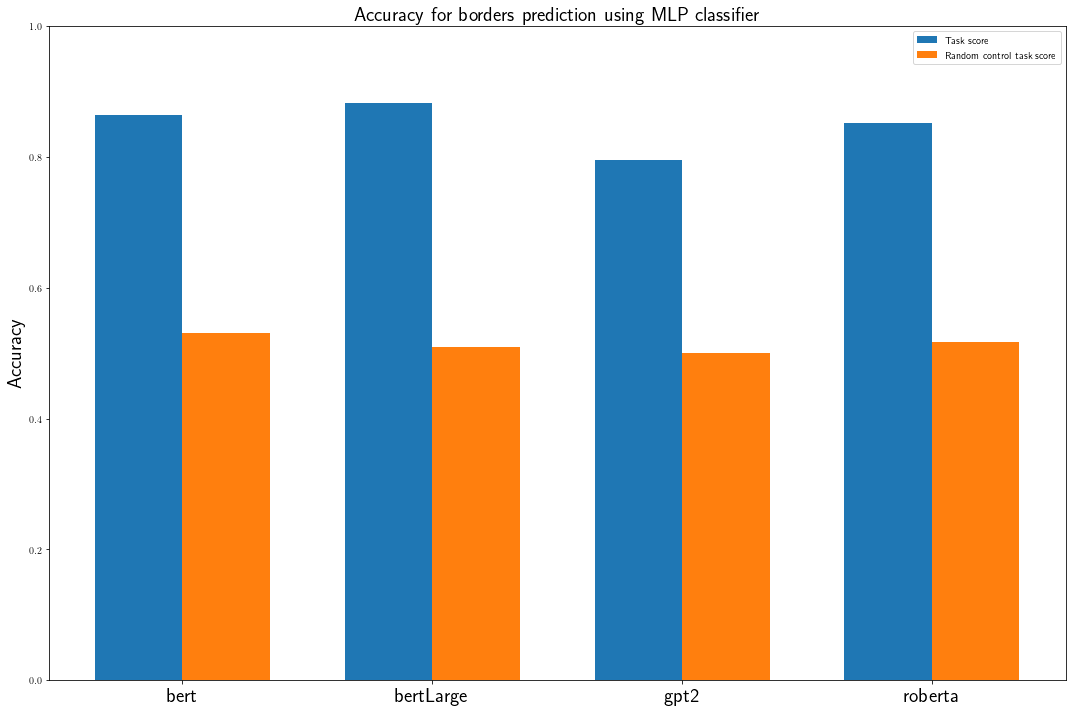

In [70]:
compare_models(model=MLPClassifier,model_kwargs={'max_iter':1000,'solver':'adam'},
               datasets_dict=datasets_countries
               f_dataset=create_border_dataset,f_dataset_kwargs={'non_border_size':500},
               LMs=['bert','bertLarge','gpt2','roberta'],ylims=(0,1),y_label='Accuracy',
               fig_title='Accuracy for borders prediction using MLP classifier',
              fig_name='4layers_borders_mlp.png')

## Predicting some country indexes and attributes

In [58]:
embeddings = datasets_countries['bertLarge']['avg']
X,y = create_CountryProps_dataset(embeddings,total_size=1000,attribute='HDI')
y

0      0.511
1      0.795
2      0.748
4      0.868
5      0.581
       ...  
239    0.711
240    0.704
245    0.470
246    0.584
247    0.571
Name: HDI, Length: 189, dtype: float64

In [65]:
reg = MLPRegressor(max_iter=1000,solver='adam')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
reg.fit(X_train,y_train)
evs(reg.predict(X_test),y_test)

-0.6262683430649767

**PREDICTING HUMAN DEV. INDEX**

bert -----------------------
random control: 100%|███████████████████████████| 10/10 [00:41<00:00,  4.18s/it]
bertLarge -----------------------
random control: 100%|███████████████████████████| 10/10 [01:05<00:00,  6.54s/it]
gpt2 -----------------------
random control: 100%|███████████████████████████| 10/10 [00:28<00:00,  2.88s/it]
roberta -----------------------
random control: 100%|███████████████████████████| 10/10 [00:42<00:00,  4.26s/it]


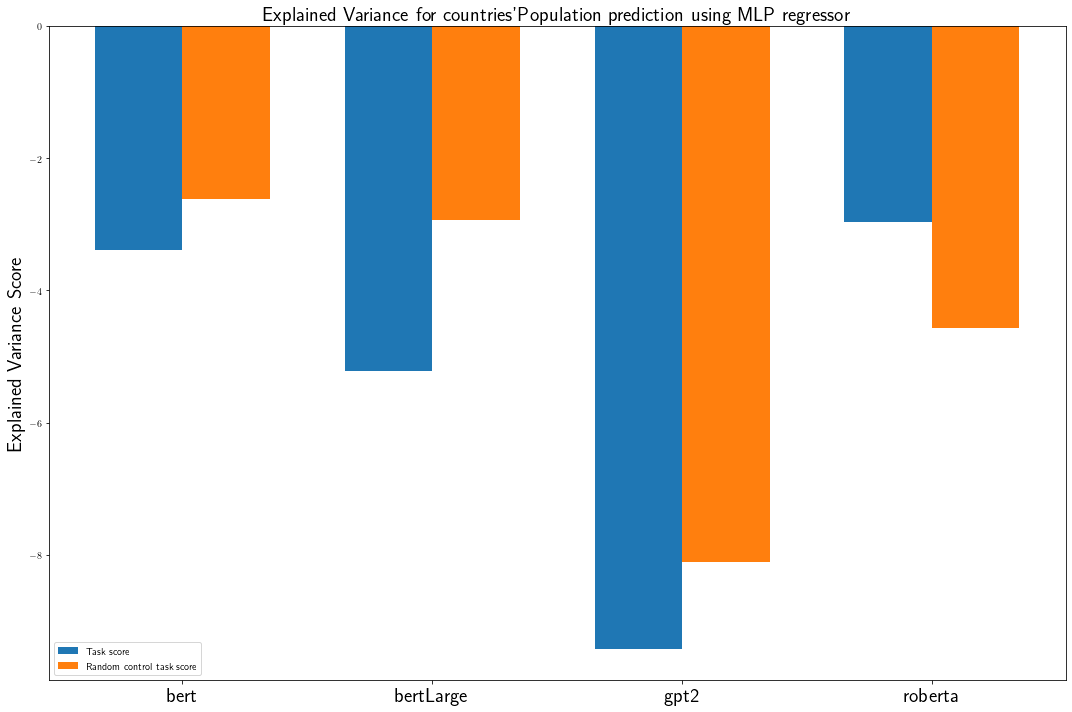

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (

In [23]:
attr = 'Population'
warnings.filterwarnings("ignore")
compare_models(model=MLPRegressor,model_kwargs={'max_iter':1000,'random_state':0},
               datasets_dict=datasets_countries,
               f_dataset=create_CountryProps_dataset,f_dataset_kwargs={'total_size':1000,'attribute':attr},
               LMs=['bert','bertLarge','gpt2','roberta'],y_label='Explained Variance Score',
               fig_title='Explained Variance for countries\''+attr+' prediction using MLP regressor',
              fig_name='4layers_countries_'+attr.lower()+'.png',n_test=10,metrics=evs,seed=0,return_scores=True)
warnings.filterwarnings("default")

## Predicting whether 2 cities belong to the same country

In [136]:
embeddings = datasets['bertLarge']['avg']
X,y,pairs = create_SameCountry_dataset(embeddings,total_size=1000,out_pairs=True)

dataset creation: 100%|██████████| 500/500 [00:01<00:00, 385.70it/s]


In [139]:
print('number of identical pairs : '+str(sum([pair[0]==pair[1] for pair in pairs])))

number of identical pairs : 20


bert -----------------------
random control: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it]
bertLarge -----------------------
random control: 100%|██████████| 10/10 [00:37<00:00,  3.73s/it]
gpt2 -----------------------
random control: 100%|██████████| 10/10 [01:27<00:00,  8.75s/it]
roberta -----------------------
random control: 100%|██████████| 10/10 [00:48<00:00,  4.89s/it]


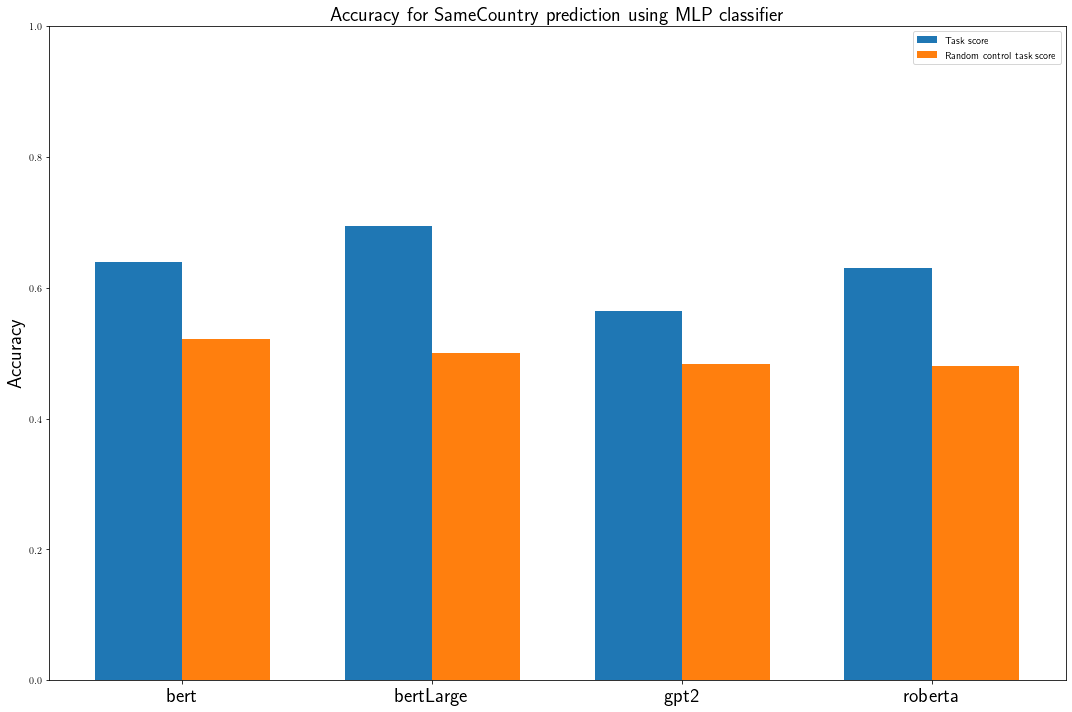

In [142]:
compare_models(model=MLPClassifier,model_kwargs={'max_iter':1000,'solver':'adam'},
               datasets_dict=datasets,
               f_dataset=create_SameCountry_dataset,f_dataset_kwargs={'total_size':1000},
               LMs=['bert','bertLarge','gpt2','roberta'],ylims=(0,1),y_label='Accuracy',
               fig_title='Accuracy for SameCountry prediction using MLP classifier',
              fig_name='4layers_SameCountry_mlp.png')

## Predicting cities' population

bert -----------------------
random control: 100%|██████████| 1/1 [01:11<00:00, 71.40s/it]
bertLarge -----------------------
random control: 100%|██████████| 1/1 [01:35<00:00, 95.42s/it]
gpt2 -----------------------
random control: 100%|██████████| 1/1 [01:06<00:00, 66.15s/it]
roberta -----------------------
random control: 100%|██████████| 1/1 [01:14<00:00, 74.41s/it]


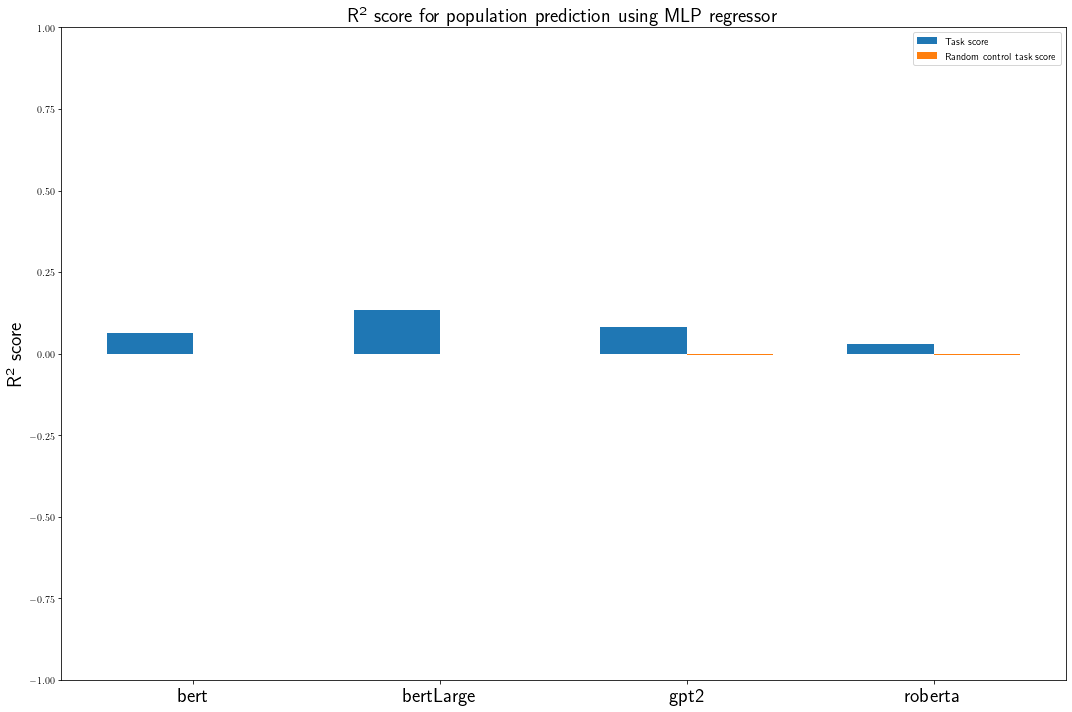

In [156]:
warnings.filterwarnings("ignore")
compare_models(model=MLPRegressor,model_kwargs={'max_iter':1000},
               datasets_dict=datasets,
               f_dataset=create_population_dataset,f_dataset_kwargs={'total_size':1000},
               LMs=['bert','bertLarge','gpt2','roberta'],ylims=(-1,1),y_label='R² score',
               fig_title='R² score for population prediction using MLP regressor',
              fig_name='4layers_population_mlp.png',n_test=1)
warnings.filterwarnings("default")

In [151]:
lm = 'bertLarge'
ctx = 'avg'
X = datasets[lm][ctx]
y = cities.Population

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
reg = MLPRegressor(max_iter=2000)
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

/home/bastien/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.1982869093319105